# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [26]:
!pip install wordcloud

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from scipy import stats
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bjorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Bjorn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [28]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [29]:
# Make a dataframe of emails/counts for later exploration and visualization
# I am instantiating an actual dataframe object vs. just a groupby series to allow me to
# apply more dataframe specific functions later.
article_count_df = df.groupby('email')['article_id'].count().to_frame(name = 'count').reset_index()
article_count_df.sort_values(by="count")

,email,count
2116,6755c5d49a97e785583f65a92f72bc09459905a9,1
1329,3fbe4978a20ee5ddc07648f2762b808ea18cedd1,1
3160,9c4b5dda1282c94128a7dc778951a313cce8055b,1
1327,3fac88958dc7903b380743597f44a79cf76ea128,1
4857,efdb4c363358224cd99d45053e2dbddf659e25ce,1
1325,3faaf951e4fa83cd67032688320d03d832ae708c,1
4858,efded4d12cb4d1f53515e503d4ad3c4ca850a4da,1
1321,3f7be78857cda042074028beed41d088e5dd6a99,1
3165,9cadbc14289d0db3937f00f4f2aab8d49b49680a,1
3166,9cb9845ca344b23b49ad94f4fddbcf95fedc0617,1


<Figure size 432x288 with 0 Axes>

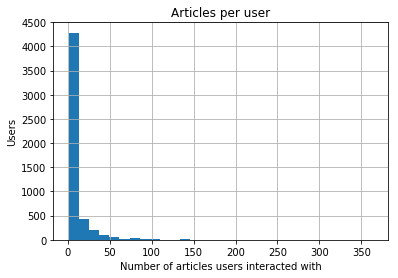

In [30]:
# Visualizing the data
def MakeHistogram(dfIn, strXLabel, strYLabel, strTitle, intBins):
    plt.figure()
    dfIn.hist(bins=intBins)
    plt.xlabel(strXLabel)
    plt.ylabel(strYLabel)
    plt.title(strTitle)
    
MakeHistogram(article_count_df, 'Number of articles users interacted with','Users', 'Articles per user', 30)

Let's describe the full population

In [31]:
article_count_df.describe()

,count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [32]:
# A bit messy due to outliers...let's "zoom in"
def drop_numerical_outliers(df, z):
    '''
    INPUT: 
    df - dataframe to trim
    z  - z threshold
    OUTPUT:
    df_new - trimmed dataframe
    '''
    # Constraints index will contain `True` or `False` for values outside of threshold
    constraints = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z, reduce=False) \
        .all(axis=1)
    # Drop values set to be rejected and make new dataframe to return
    df_new =  df.drop(df.index[~constraints])
    return df_new

article_count_df_trimmed =  drop_numerical_outliers(article_count_df, 3)


C:\Users\Bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions
  # This is added back by InteractiveShellApp.init_path()


In [33]:
article_count_df_trimmed.head()

,email,count
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


<Figure size 432x288 with 0 Axes>

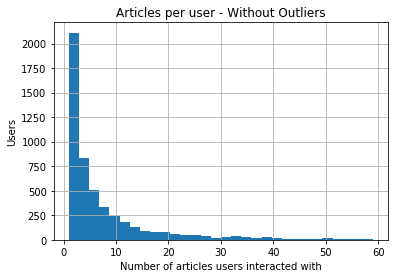

In [34]:
MakeHistogram(article_count_df_trimmed, 'Number of articles users interacted with','Users', 'Articles per user - Without Outliers', 30)

Ok, a bit easier to see ... useful for visually validating the further quantitative exploration below. Most folks really read between 3 and 59 articles, even though the full dataframe has outliers up to 364 articles, but those aren't really all that representative for the population.

In [35]:
article_count_df_trimmed.describe()

,count
count,5053.000000
mean,7.283396
std,9.816832
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,59.000000


Very close mean, but wildly different max!

In [36]:
print('50% of individuals interact with {} articles or fewer'.format(article_count_df['count'].median()))
print('The maximum number of user-article interactions by any one user is {}'.format(article_count_df['count'].max()))

50% of individuals interact with 3.0 articles or fewer
The maximum number of user-article interactions by any one user is 364


In [37]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [38]:
# Find and explore duplicate articles
# Determine non-unique article IDs
df_content['article_id'].nunique()

1051

In [39]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(keep = 'first', inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [40]:
# The number of unique articles that have at least one interaction - query df dataframe
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform - query df_content dataframe
total_articles = df_content['article_id'].nunique()

# The number of unique users - query df dataframe by email column
unique_users = df['email'].nunique()

# The number of user-article interactions - determine df rows
user_article_interactions = df.shape[0]

# Print it all out
print('The number of unique articles that have an interaction with a user is {}'.format(unique_articles))
print('The number of unique articles in the dataset (whether they have any interactions or not) is {}'.format(total_articles))
print('The number of unique users in the dataset (excluding null values) is {}'.format(unique_users))
print('The number of user-article interactions in the dataset is {}'.format(user_article_interactions))


The number of unique articles that have an interaction with a user is 714
The number of unique articles in the dataset (whether they have any interactions or not) is 1051
The number of unique users in the dataset (excluding null values) is 5148
The number of user-article interactions in the dataset is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [41]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(round(df['article_id'].value_counts().index[0], 1))
# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().values[0]
# Adding this out of curiosity...what was the name of the article?
title_of_article = df_content.loc[df['article_id'] == df['article_id'].value_counts().index[0], 'doc_full_name'].iloc[0]
print('The most viewed article is {}'.format(most_viewed_article_id))
print('This article was viewed {} times'.format(max_views))
print('The title of this article is \'{}\''.format(title_of_article))


The most viewed article is 1429.0
This article was viewed 937 times
The title of this article is 'This Week in Data Science (April 18, 2017)'


In [42]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


Let's visualize a bit of the content, too. 

In [43]:
def GetNouns(text):
    '''
    INPUTS:
    text - text as string to extract nouns from
    
    OUTPUTS:
    nounstring - a space-delimited string of nouns    
    '''
    # function to test if something is a noun - nouns are much more
    # meaningful than other parts of speech to get an idea for topic areas
    is_noun = lambda pos: pos[:2] == 'NN'
    # tokenize, extract nouns
    tokenized = nltk.word_tokenize(text)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    # concatenate list to noun string with space delimiter
    nounstring = " "
    nounstring = nounstring.join(nouns)
    return nounstring
    

def MakeWordCloud(text, xSize, ySize, custom_stopwords, strTitle, intMaxWords):
    '''
    INPUTS:
    text - text to visualize as wordcloud
    xSize - horizontal size of plt
    ySize - vertical size of plt
    custom_stopwords - custom list of words to exclude from word cloud
    strTitle - title for plt
    intMaxWords - maximum words in word cloud
    
    OUTPUTS:
    none - draws a word cloud
    '''
    text = GetNouns(text)

    # kick out meaningless words
    stopwords = set(STOPWORDS)
    stopwords.update(custom_stopwords)

    wordcloud = WordCloud(stopwords= stopwords, max_font_size=200, max_words=intMaxWords, 
                          background_color="white").generate(text)
    plt.figure(figsize=(xSize, ySize))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(strTitle)
    plt.show()

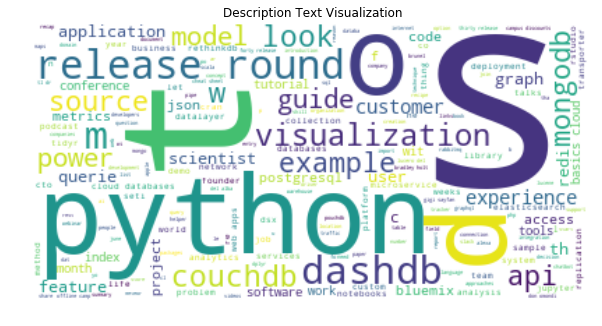

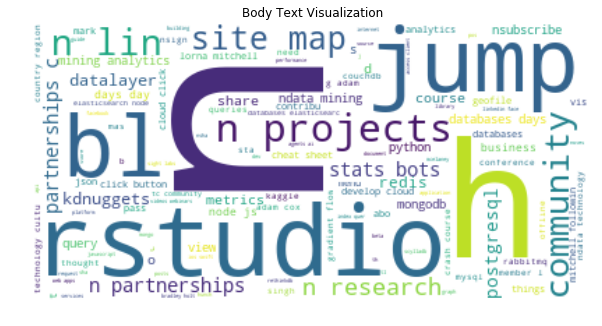

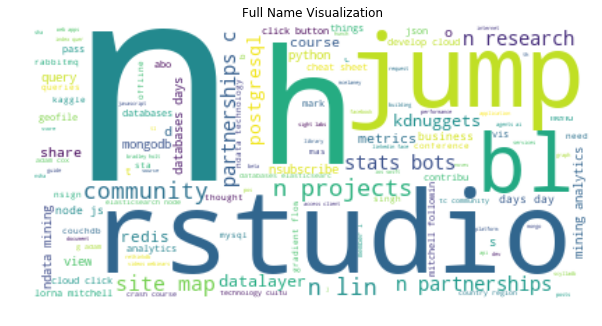

In [44]:
# Import full body or just descriptions
text_description = df_content.doc_description.to_string().lower()
text_body = df_content.doc_body.to_string().lower()
text_full_name = df_content.doc_full_name.to_string().lower()

# create custom stopwords list
custom_stopwords = ["follow", "sign", "articles", "logo", "compose", "free", "content", "main", "skip", 
                     "ibm", "developerworks","homepage", "login", "learning", "developer", "deve", 
                     "blocked", "unblock", "navigation", "pat", "subscribe", "home", "blog", 
                     "started", "united states", "states", "search", "loading", "enterprise pricing",
                     "searchloading", "pricing", "da", "nshare", "enterprise", "united", "lab", "data", "use",
                     "article", "using", "database", "cloudant", "learn", "machine", "create", "video", "see"
                     "look", "show", "shows", "week", "news", "post", "series", "time", "notebook", "tool",
                     "science", "version", "watch", "twitter", "watson", "bi", "app", "way", "talk", "today",
                     "spark", "apache", "service", "overview", "part", "bird", "de", "nibm", "package",
                     "lot"]

# Make word clouds
MakeWordCloud(text_description, 10, 10, custom_stopwords, "Description Text Visualization", 500)
MakeWordCloud(text_body, 10, 10, custom_stopwords, "Body Text Visualization", 500)
MakeWordCloud(text_body, 10, 10, custom_stopwords, "Full Name Visualization", 500)



In [45]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [46]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # One line solution - inspired by https://github.com/angang-li/recommendation_ibm/blob/master/Recommendations_with_IBM.ipynb
    top_articles = df.title.value_counts().iloc[:n].index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Inspired by the above one line solution...
    top_articles_ids = df.article_id.value_counts().index[:n].tolist()
 
    return top_articles_ids # Return the top article ids

In [49]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [50]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [51]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Remove duplicates
    df = df.drop_duplicates(subset=['user_id','article_id'])
    
    # Create matrix view of dataframe by using unstack function
    # Also filling NaN with zeros for convenience
    user_item=df.groupby(['user_id','article_id']).count().unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [52]:
# Let's take a look at the user_item matrix
user_item

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
9             0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    1.0   
10            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11            0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
12            0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
13            0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
14            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
15            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
17            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
19            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
20            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
21            0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
22            0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
23            0.0    1.0    0.0    0.0    0.0    1.0    1.0    0.0    1.0   
24            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
26            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
28            0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
29            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
5120          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5121          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5122          0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
5123          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5124          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5125          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5126          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5127          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5128          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5129          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5130          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5131          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5132          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5133          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5134          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5135          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5136          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5137          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5138    

As expected, a very sparse matrix!

In [53]:
user_item.describe()

title                                                      \
article_id       0.0          2.0          4.0          8.0          9.0      
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.002331     0.008545     0.002525     0.015925     0.001942   
std            0.048224     0.092054     0.050188     0.125199     0.044031   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

                                                                             \
article_id       12.0         14.0         15.0         16.0         18.0     
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.019227     0.017285     0.005050     0.010876     0.013206   
std            0.137335     0.130344     0.070887     0.103729     0.114169   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

               ...                                                           \
article_id     ...            1434.0       1435.0       1436.0       1437.0   
count          ...       5149.000000  5149.000000  5149.000000  5149.000000   
mean           ...          0.006992     0.014566     0.054768     0.024665   
std            ...          0.083331     0.119819     0.227549     0.155117   
min            ...          0.000000     0.000000     0.000000     0.000000   
25%            ...          0.000000     0.000000     0.000000     0.000000   
50%            ...          0.000000     0.000000     0.000000     0.000000   
75%            ...          0.000000     0.000000     0.000000     0.000000   
max            ...          1.000000     1.000000     1.000000     1.000000   

                                                                             \
article_id       1439.0       1440.0       1441.0       1442.0       1443.0   
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.008351     0.001554     0.001165     0.000777     0.002331   
std            0.091011     0.039390     0.034120     0.027864     0.048224   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

                         
article_id       1444.0  
count       5149.000000  
mean           0.000971  
std            0.031150  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000  

[8 rows x 714 columns]

In [54]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [55]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    # Using dot product of transposed user item for matrix multiplication similarity product
    similar_users = user_item.dot(np.transpose(user_item))
  
    # sort by similarity
    similar_users.sort_values(user_id, ascending=False, inplace = True)

    # create list of just the ids and remove the own user's id at the same time
    similar_users = similar_users.loc[similar_users.index!=user_id]
   
    # Convert index values to list and return
    most_similar_users = similar_users.index.values.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [56]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [57]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Instantiate empty array
    article_names = []
    # Iterate through input list of article ids
    for article_id in article_ids:
        # get actual title from data frame where id matches in title column
        article_title = df[df['article_id'] == float(article_id)].max()['title']
        # append to array
        article_names.append(article_title)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Retrieve article ids that the user has actually interacted with
    # enter at loc that matches user_id, retrieve all '1s' that indicate interaction and
    # convert the index values to a list
    article_id_list = user_item.loc[user_id][user_item.loc[user_id] == 1].title.index.values.tolist()
    # type cast to string with inline function as this will later be passed in as a string parameter
    article_id_list = [str(article_id) for article_id in article_id_list]
    # get corresponding names in convenience function above
    article_names = get_article_names(article_id_list)
    
    return article_id_list, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find user group most similar to our current user 
    similar_user_group = find_similar_users(user_id)
    
    # Get articles already read by user so we don't re-recommend
    user_article_ids = set(get_user_articles(user_id)[0])
    
    # Instantiate empty array to hold recommendations
    recommendations = []
    # Loop through similar user group
    for similar_user in similar_user_group:
        # Retrieve articles for similar user
        similar_user_article_ids = set(get_user_articles(similar_user)[0])
        # Only append to recommendations if user hasn't already read/interacted
        recommendations += list(set(similar_user_article_ids) - set(user_article_ids))
        # Exit for loop if enough recommendations have been retrieved
        if len(recommendations) > m:
            break
 
    return recommendations[:m] # return your recommendations for this user_id

In [58]:
# Check Results
get_article_names(user_user_recs(1300, 10)) # Return 10 recommendations for user 1

['open sourcing 223gb of driving data – udacity inc',
 'a visual explanation of the back propagation algorithm for neural networks',
 'machine learning and the science of choosing',
 'insights from new york car accident reports',
 'when machine learning matters · erik bernhardsson',
 'this week in data science (february 7, 2017)',
 'jupyter notebook tutorial',
 'access mysql with r',
 'intents & examples for ibm watson conversation',
 'pearson correlation aggregation on sparksql']

In [59]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [60]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Create dataframe with columns as per doc string
    colNames = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df = pd.DataFrame(columns = colNames)
    
    # Loop through all entries in user_item matrix
    for i in user_item.index.values:
        # Skip if self
        if i == user_id:
            continue
        #Assign temporary variable     
        neighbor_id = i
        # Calculate similarity for neighbor using transpose dot product
        similarity = user_item[user_item.index == user_id].dot(user_item.loc[i].T).values[0]
        # Get total number of interactions
        num_interactions = user_item.loc[i].values.sum()
        # Add values to dataframe
        neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    # Bulk typecasting
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    # Sort
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Create empty array for candidates
    recommendation_candidates = []
    name_ids = []
    # Use convenience function from above to retrieve similar users dataframe
    top_similar_users_df = get_top_sorted_users(user_id)
    # Convert neighbor_ids to list
    users_list = top_similar_users_df['neighbor_id'].values.tolist()

    # Get article list for user in question
    article_ids_list = list(set(df[df['user_id'] == user_id]['article_id'].values.tolist()))
    
    # Loop through similar users 
    for id in users_list:
        # Append everything they read to a candidate list
        recommendation_candidates += df[df['user_id'] == id]['article_id'].values.tolist()
    # Convert list to set for easier iteration
    recommendation_candidates = list(set(recommendation_candidates))
    # Purge things the user has already read
    recommendation_candidates = [ x for x in recommendation_candidates if x not in article_ids_list ]
    
    # Create list of finalists from cleansed candidate set
    recommendations_finalists = df[df.article_id.isin(recommendation_candidates)][['article_id','title']].drop_duplicates().head(m)
    # Prepare return variables in the form of lists from finalists dataframe
    recs = recommendations_finalists['article_id'].values.tolist()
    rec_names = recommendations_finalists['title'].values.tolist()
    
    
    return recs, rec_names

In [61]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1314.0, 1429.0, 1338.0, 1276.0, 1432.0, 593.0, 1185.0, 993.0, 14.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'upload files to ibm data science experience using the command line', 'classify tumors with machine learning', 'configuring the apache spark sql context', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [62]:
# Retrieve dataframe, then look at zero-th member
print(get_top_sorted_users(1).iloc[0])

neighbor_id         3933.0
similarity            35.0
num_interactions      35.0
Name: 3933, dtype: float64


In [63]:
# Retrieve dataframe, then look at ninth member, as counting basis is zero
print(get_top_sorted_users(131).iloc[9])

neighbor_id         242.0
similarity           25.0
num_interactions     59.0
Name: 242, dtype: float64


In [64]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [65]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

This is an example of the well-known 'cold start' problem. We don't have a reading history so we can't use our matrix multiplication and user similarity algorithms from above. 
Potential workarounds are
- Simply show the most popular articles
- Offer the user a short quiz to get areas of interest and then feed those areas of interest with corresponding keywords into a content-based approach
- If available from a user/customer profile, extract additional information about the user from a signup process...maybe they disclosed areas of interest or have previous behavior on the platform that lets us guess what they might want to see. Specific example: Did they run an Auto AI experiment in Watson Studio? What was the experiment about?

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [66]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
print(new_user_recs)


[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [67]:
assert set(new_user_recs) == set([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [68]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [69]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [70]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [71]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [72]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)

In [73]:
# Quick check to make sure it worked
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

The built-in function works because we have a user item matrix that is perfectly populated with zero missing values. If there had been missing values, we would have to use a gradient-descent based approach vs. an algebraic approach as missing values make the mathematical derivation of eigenvectors and eignevalues required for SVD impossible. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

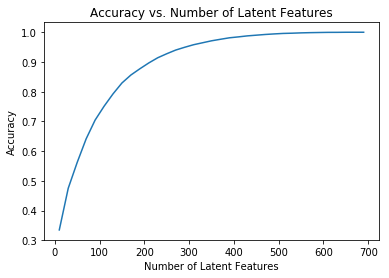

In [74]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [75]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Training items using earlier convenience function
    user_item_train = create_user_item_matrix(df_train)
    # Test items using earlier convenience function
    user_item_test = create_user_item_matrix(df_test)
    
    # Create list from set of index values in test group
    test_idx = list(set(user_item_test.index))
    # Create list from set of columns in test group
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [76]:
# Exploratory data analysis of test/train sets
print(user_item_train.shape)
print(user_item_test.shape)
print(len(test_idx))
print(len(test_arts))

(4487, 714)
(682, 574)
682
574


In [77]:
# Find users that are in both sets
users_in_common = list(set(user_item_test.index) & set(user_item_train.index))
# Find articles in both sets
articles_in_common  = list(set(user_item_test.columns) & set(user_item_train.columns))
# Do the math
stranded_users = user_item_test.shape[0] - len(users_in_common)
stranded_articles = user_item_test.shape[1] - len(articles_in_common)
print('Users in common: ', len(users_in_common))
print('Articles in common: ', len(articles_in_common))
print('Stranded users', stranded_users)
print('Stranded articles', stranded_articles)

Users in common:  20
Articles in common:  574
Stranded users 662
Stranded articles 0


In [78]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

# NOTE: Udacity reviewer, if you are reading this, the dictionary below is referencing 'movies' when it should say 'articles'
sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [79]:
# Fit SVD on the user_item_train matrix
# Fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int'), full_matrices=False) 
# Print out shapes to get an idea of the training set size
print('train: ', u_train.shape, s_train.shape, vt.shape)

train:  (4487, 714) (714,) (714, 714)


In [80]:
# Let's find the 'testable overlap' of users and articles shared across train and test set
train_common_index = user_item_train.index.isin(test_idx)
train_common_columns = user_item_train.columns.isin(test_arts)

# Now we need to focus only on the parts of the respective matrices that can actually be predicted given the 
# (somewhat limited) overlap between train and test sets - if they don't overlap, we can't produce a matrix dot product!

u_test = u_train[train_common_index, :]
vt_test= vt_train[:, train_common_columns]
print('test: ', u_test.shape, vt_test.shape)

test:  (20, 714) (714, 574)


In [81]:
# Code below inspired by https://github.com/A-Nuru/Recommendations-with-IBM/blob/master/Recommendations_with_IBM.ipynb
test_users = np.intersect1d(user_item_train.index, user_item_test.index)
test_articles = user_item_train.columns.intersection(user_item_test.columns)
user_item_test_predictable = user_item_test.loc[test_users, test_articles]

In [82]:
# Predict test data
# Create evenly distributed feature space using np.arange()
num_latent_feats = np.arange(10,700+10,20)
# Create arrays to hold sum of errors
sum_errs_train = []
sum_errs_test = []
all_errs = []

# Iterate through latent feature candidates
for k in num_latent_feats:
    # Restructure matrices with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # Calculate dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    # Now compute error for each prediction vs. actual value in overlapped set
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test_predictable, user_item_test_preds)
    
    # Sum total errors and store
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

Time to plot the results!

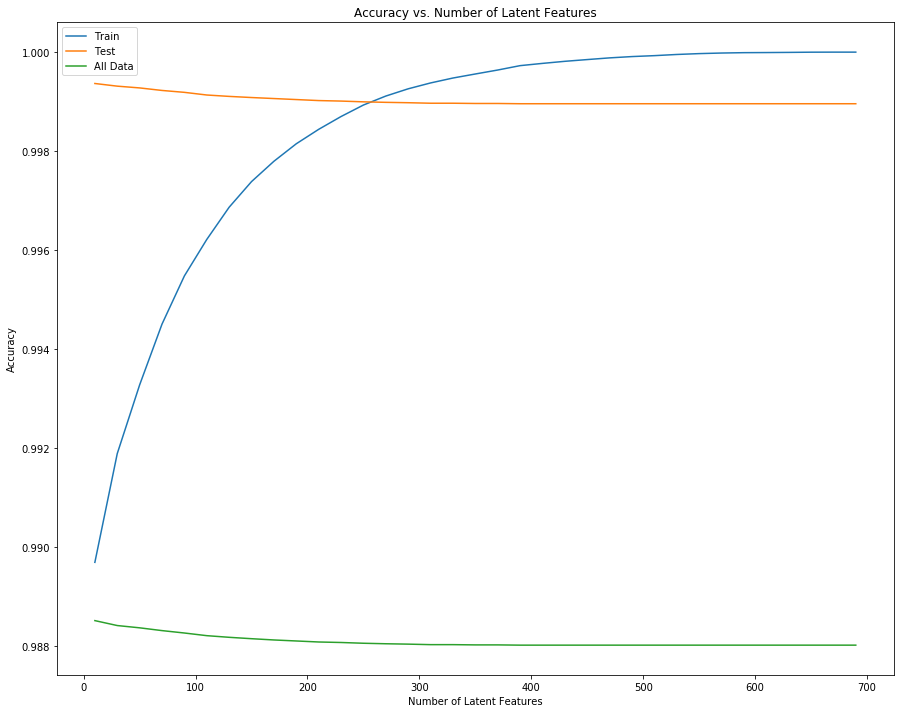

In [83]:
plt.figure(figsize=(15,12))
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

- We observe that an increase in latent features does not increase test / all data accuracy. This indicates overfitting to the training data by 'overengineering' the latent feature space. For best results with the SVD approach, it seems advisable to keep latent features to < 50 (which is still a large number of implied common features across all articles from a conceptual point of view)
- Significantly, only 20 users in the test set were present in the training set. One way to get more data about the appropriate number of latent features would be to use more sophisticated test/train split approaches than the one used above where we simply used head/tail to split the data set. We should also evaluate if there are factors like a potential chronological order of the data set makes a naive split inappropriate, etc.
- Should we find out that the cold-start problem makes an SVD approach impractical, we should consider alternatives. Three potential options are shown below
  - Use a rank-based approach to simply go by article popularity
  - Use a content-based approach, potentially combined with a visual starting point such as creating a word cloud for previously clustered articles (using k-means or similar clustering) and the ask the user to 'pick the word cloud that best reflects what you are looking for' 
  - Provide the user an option to 'opt in' to allowing our system access to e.g. their Github or Twitter feed. Based on data present in those repositories, we could then create additional features to optimize our article recommendations. What did the user tweet about? If it is relevant to coding, can we suggest articles based on tweets? Alternatively, is there code in the user's GitHub that can serve as a useful jumping-off point for further exploration? We may recommend articles that are reflective of the dominant languages and techniques used in existing GitHub repositories. To add variety, we may also add articles that are very dissimilar to the existing code to create new perspectives. 
- Regardless of approach, careful A/B testing with appropriate sized and selected sample populations will deliver more quantitative insights to determine the optimal approach